<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://erachelson.github.io/RLclass_MVA/">https://erachelson.github.io/RLclass_MVA/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Chapter 6: Monte Carlo policy gradient algorithms</div>

In this chapter we first depart from the (approximate) dynamic programming framework we have worked with so far. We turn back to a criterion for optimality we introduced in the first chapters, namely the average value of a policy across (starting) states. We explore the question of writing the gradient of this criterion with respect to policy parameters, which leads us to the very important policy gradient theorem and the family of policy gradient algorithms.

<div class="alert alert-success">

**Learning outcomes**   
By the end of this chapter, you should be able to:
- recall and explain the policy gradient theorem for infinite horizon problems,
- explain the problem of gradient estimate variance and the introduction of baselines,
- implement a REINFORCE algorithm for discrete action spaces,
- implement an A2C algorithm for discrete action spaces.

Additionally, after doing the homework, you should be able to:
- use vectorized environments to accelerate sample collection in policy gradient algorithms,
- implement REINFORCE and A2C for continuous action spaces,
- derive the policy gradient theorem for finite horizon problems,
- explain and implement a generalized advantage estimation method within a policy gradient algorithm,
- derive the formulation of off-policy policy gradients,
- implement natural policy gradients, TRPO and PPO,
- explain and implement the "OpenAI evolution strategy" and the "Canonical evolution strategy" for gradient-free direct policy search.
</div>

# Policy gradient methods

<div class="alert alert-success">

**Bottomline question:**   
The previous chapters have focussed on *action-value methods*; they aimed at estimating $Q^*$ in order to deduce $\pi^*$, or they jointly optimized $Q$ and $\pi$. Could we directly optimize $\pi$?
</div>

Suppose we have a policy $\pi_\theta$ parameterized by a vector $\theta$. Our goal is to find the parameter $\theta^*$ corresponding to $\pi^*$.

Remarks:
- $\pi_\theta$ might not be able to represent $\pi^*$. We will take a shortcut and call $\pi^*$ the best policy among the $\pi_\theta$ ones.
- For discrete state and action spaces, the tabular policy representation is a special case of policy parameterization.
- Policy parameterization is a (possibly useful) way of introducing prior knowledge on the set of the desired policies.
- The optimal deterministic policies might not belong to the policy subspace of $\pi_\theta$, thus it makes sense to consider stochastic policies for $\pi_\theta$.
- It makes even more sense to consider stochastic policies that it opens the family of environments that we can tackle, like partially observable MDPs or multi-player games.

For stochastic policies, we shall write $\pi_\theta(a|s)$.

In the remainder of the chapter, we will assume that $\pi_\theta$ is differentiable with respect to $\theta$.

Suppose now we define some performance metric $J(\pi_\theta) = J(\theta)$. If $J$ is differentiable and a stochastic estimate $\tilde{\nabla}_\theta J(\theta)$ of the gradient is available, then we can define the stochastic gradient ascent update procedure:
$$\theta \leftarrow \theta + \alpha \tilde{\nabla}_\theta J(\theta).$$

We will call **policy gradient methods** all methods that follow such a procedure (whether or not they also learn a value function or not).

<div class="alert alert-success">

**Policy gradient method**   
We call **policy gradient method** any method that performs stochastic gradient ascent on the policy's parameters.  
Given a stochastic estimate $\tilde{\nabla}_\theta J(\theta)$ of a policy's performance criterion with respect to the policy's parameters, such a method implements the update procedure: 
$$\theta \leftarrow \theta + \alpha \tilde{\nabla}_\theta J(\theta).$$
</div>

Remarks: 
- Note that $J$ is a generic criterion. For example, $J$ could be defined as the $\gamma$-discounted value of a starting state (or a distribution of starting states), or as the undiscounted reward over a certain horizon, or as the average reward.
- Note that this family of methods can use any gradient estimate for $\tilde{\nabla}_\theta J(\theta)$: formal calculus, finite differences, automated differentiation, evolution strategies, etc.
- Why is it interesting to look at policy gradient methods? Because there is no maximization step ($\max_a Q(s,a)$) during evaluation, which might be costly, especially for continuous actions, but only a call to $\pi_\theta(s)$ (or a draw from $\pi_\theta(a|s)$). This argument makes actor-critic architectures or direct policy search a method of choice for continuous actions domains (especially common in Robotics) and Policy Gradient is one of them.
- When do policy gradient approaches outperform value-based ones? It's hard to give a precise criterion; it really depends on the problem. One thing that comes into play is how easy it is to approximate the optimal policy or the optimal value function. If one is simpler than the other (by "simpler", we mean "it is easier to find a parameterization whose spanned function space almost includes the function to approximate"), then it is a good heuristic to try to approximate it. But this criterion might itself be hard to assess.

**Notations**

- We consider probability density functions $p(X)$ for all random variables $X$.
- For a policy $\pi_\theta$ and a random variable $X$ we write indifferently $p(X|\pi_\theta) = p(X|\theta)$.
- We will write $\pi_\theta(s)$ the policy's distribution over actions in $s$, and $\pi_\theta(a|s)$ the probability that this policy picks action $a$ in $s$.
- A trajectory is noted $\tau = (s_t,a_t)_{t\in \mathbb{N}}$.
- The state random variable at step $t$ is $S_t$ and its law's density is $p_t(s)$.
- The action random variable at step $t$ is $A_t$.

# The policy gradient theorem

## Reminder on the policy optimization objective

Recal the policy optimization objective defined in previous chapters, given a distribution $p_0$ on states:  
$$J(\pi) = \mathbb{E}_{s \sim p_0} \left[ V^{\pi} (s) \right].$$
Or equivalently:  
$$J(\pi) = \mathbb{E}_{(s_i,a_i)_{i \in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t r(s_t,a_t)  | \pi, p_0 \right].$$

In the sum above:
- $s_0$ is drawn according to $p_0$,
- $a_0$ is drawn according to $\pi(s_0)$,
- all subsequent $s_{t+1}$ are drawn according to $p(s_{t+1}|s_t,a_t)$,
- and all subsequent actions $a_{t+1}$ are drawn according to $\pi(s_{t+1})$.

Since $p_0$ is supposed known and fixed, we will omit it in the rest of this chapter for the sake of readability.  
We can switch the sum and the expectation and get:  
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \mathbb{E}_{(s_i,a_i)_{i \in \mathbb{N}}} \left[ r(s_t,a_t)  | \pi \right].$$
But $\mathbb{E}_{(s_i,a_i)_{i \in \mathbb{N}}} \left[ r(s_t,a_t)  | \pi \right] = \mathbb{E}_{s_t,a_t} \left[ r(s_t,a_t)  | \pi \right]$. So:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \mathbb{E}_{s_t,a_t} \left[ r(s_t,a_t)  | \pi \right].$$
Now let's introduce the density of $(s_t,a_t)$:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \int_S \int_A r(s_t,a_t) p(s_t,a_t|\pi) ds_t da_t.$$
But $p(s_t,a_t|\pi) = p(s_t|\pi) p(a_t|s_t,\pi)$. By definition, $p(s_t|\pi) = p_t(s|\pi)$ and $p(a_t=a|s_t=s,\pi) = \pi(a|s)$. So:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \int_S \int_A r(s,a) p_t(s|\pi) \pi(a|s) ds da.$$
Let us isolate the terms that concern only states:
$$J(\pi) = \int_S \left[ \int_A r(s,a) \pi(a|s) da \right] \sum_{t=0}^\infty \gamma^t p_t(s|\pi) ds.$$
Let's note $\rho^\pi(s) = \sum_{t=0}^\infty \gamma^t p_t(s|\pi)$. We have encountered this quantity in previous chapters and called it the *state occupancy measure under policy $\pi$ and starting distribution $p_0$*. It is not a proper distribution per se (it sums to $\frac{1}{1-\gamma}$), and is sometimes also called the *improper state distribution under policy $\pi$* or the *improper state visitation frequency under policy $\pi$*. Then we have:
$$J(\pi) = \int_S \left[ \int_A r(s,a) \pi (a|s) da \right] \rho^\pi(s) ds.$$
And so finally, with a slight notation abuse because $\rho^\pi$ is not a probability distribution:
$$J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ r(s,a) \right].$$

In plain words, the value of a policy $\pi$ is the average value of the rewards when states are sampled according to $\rho^\pi$ and actions are sampled according to $\pi$.

## The policy gradient theorem

The crucial problem of computing $\nabla_\theta J(\theta)$ lies in the fact that when $\theta$ changes, both $\pi$ and $\rho^\pi$ change jointly. So there seems to be no straighforward way of evaluating this gradient. One could fall back to a *finite differences* approach to estimating this gradient, but this would require trying out a series of increments $\Delta \theta$ which quickly becomes impractical (because the increment size is hard to tune, especially in stochastic systems, and also because of the sample inefficiency of the approach).

Remark:
- Let's not discard finite difference methods too quickly. They have their merits and showed great successes through methods such as [PEGASUS (Ng and Jordan, 2000)](https://arxiv.org/abs/1301.3878). Also, having random $\Delta \theta$ drawn from a Gaussian distribution is essentially what Evolution Strategies do, and [Salimans et al. (2017)](https://arxiv.org/abs/1703.03864) or [Chrabaszcz et al. (2018)](https://arxiv.org/abs/1802.08842) illustrated how that could be a scalable method to obtain gradient estimates in RL. We won't cover these topics here and leave them as exercises.  

The key result of this chapter is that one can express the gradient of $J(\theta)$ as directly proportional to the value of $Q^\pi$ and the gradient of $\pi$:
<div class="alert alert-success">

**Policy gradient theorem:**  
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q^\pi(s,a) \nabla_\theta \log\pi(a|s)\right]$$
</div>

The interpretation of this theorem is very straightforward:  
To increase the average value of policy $\pi_\theta$ over the starting distribution $p_0$, we should change $\theta$ in a direction that is a linear combination of the $\nabla_\theta \log \pi(a|s)$, where the coefficients are the expected outcomes $Q^\pi(s,a)$ of picking action $a$ in $s$.  
Since $\nabla_\theta \log \pi(a|s)$ is a direction that increases the log probability of $a$ in $s$, we can rephrase the last sentence. The policy gradient tells us:  
**To increase the value of the current policy, we should increase the log-probability of $a$ in $s$ in proportion to the expected outcome of $a$ in $s$.**

<div class="alert alert-warning">

**Exercise:**  
Why is it not really a problem that $\rho^\pi$ is not a proper probability density function?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

It is not really a problem because it is still a measure, proportional to a density function.  
We are interested in ascent *directions*, not the exact gradient. The latter is proportional to the former. So as long as we can sample from a distribution whose mass is proportional to $\rho^\pi$, we obtain a correct direction estimate.
</details>

The proof of this result is simple but a bit tedious. We can however give the general intuition. Let's consider trajectories $\tau = (s_0,a_0,r_0,...)$ drawn according to $\pi$ from the starting state. Each of these trajectories has an overall payoff of $G(\tau) = \sum_t \gamma^t r_t$, and is drawn with probability density $p(\tau|\theta)$. Then the objective function can be written:
\begin{align}
J(\theta) &= \mathbb{E}_\tau \left[ G(\tau) | \theta \right]\\
 &= \int G(\tau) p(\tau | \theta) d\tau
\end{align}

So the objective function's gradient is:
\begin{align}
\nabla_\theta J(\theta) &= \nabla_\theta \int G(\tau) p(\tau|\theta) d\tau,\\
 &= \int G(\tau) \nabla_\theta p(\tau|\theta) d\tau,\\
 &= \int G(\tau) p(\tau|\theta) \frac{\nabla_\theta p(\tau|\theta)}{p(\tau|\theta)} d\tau,\\
 &= \mathbb{E}_\tau \left[ G(\tau) \nabla_\theta \log p(\tau|\theta) \right].
\end{align}

We have used the fact that $\nabla_\theta p(\tau|\theta) = p(\tau|\theta) \nabla_\theta \log p(\tau|\theta)$, sometimes known as the *nabla-log* trick.  
Let us study the $\nabla_\theta \log p(\tau|\theta)$ term along a series of remarks.

**Remark 1: law of $s_{t+1},a_{t+1}$ given the policy and history.**  
One has $p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) p(a_{t+1} | s_{t+1}, (s_i,a_i)_{i \in [0,t]}, \theta)$.  
But the transition model is Markovian, so $p(s_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | s_t, a_t)$.  
And the law of $a_{t+1}$ is given by the policy, so $p(a_{t+1} | s_{t+1}, (s_i,a_i)_{i \in [0,t]}, \theta) = \pi_\theta(a_{t+1}|s_{t+1})$.  
Consequently:
$$p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | s_t, a_t) \pi_\theta(a_{t+1}|s_{t+1}).$$

**Remark 2: probability density of a trajectory.**  
Recall that $p(\tau|\theta) = p((s_t,a_t)_{t\in [0,\infty]}|\theta)$.  
This joint probability can be decomposed into conditional probabilities: $$p(\tau|\theta) = p(s_0,a_0|\theta) \prod_{t=0}^\infty p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta).$$ 
The previous remarks allows us to simplify to: $$p(\tau|\theta) = p(s_0,a_0|\theta) \prod_{t=0}^\infty p(s_{t+1} | s_t, a_t) \pi_\theta(a_{t+1}|s_{t+1}).$$ 
By expanding the first term into $p(s_0)\pi_\theta(a_0|s_0)$ and reordering the terms inside the product, we obtain:
$$p(\tau|\theta) = p(s_0) \prod_{t=0}^\infty p(s_{t+1} | s_t, a_t) \pi_\theta(a_t|s_t).$$

**Remark 3: grad-log-prob of a trajectory.**  
Now let us consider the full $\nabla_\theta \log p(\tau|\theta)$ term. The previous remarks tell us that  
$$\nabla_\theta \log p(\tau|\theta) = \nabla_\theta \log p(s_0) + \sum_{t=0}^\infty \left[ \nabla_\theta \log p(s_{t+1} | s_t, a_t) + \nabla_\theta \log \pi_\theta(a_t|s_t)\right].$$
But the initial state distribution and the transition model do not depend on $\theta$, so this expression boils down to:
$$\nabla_\theta \log p(\tau|\theta) = \sum_{t=0}^\infty \nabla_\theta \log \pi_\theta(a_t|s_t).$$

So eventually, we have:
$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau} \left[ G(\tau) \sum_{t=0}^\infty \nabla_\theta \log \pi_\theta(a_t|s_t) \right].$$

And if we replace $G(\tau)$ by its expression in terms of $s_t$ and $a_t$:
$$\nabla_\theta J(\theta) = \mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \left(\sum_{t=0}^\infty \gamma^t r(s_t,a_t) \right) \left( \sum_{t=0}^\infty \nabla_\theta \log \pi_\theta(a_t|s_t) \right) \right] .$$

$$\nabla_\theta J(\theta) = \mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \left(\sum_{t'=0}^\infty \gamma^{t'} r(s_{t'},a_{t'}) \right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right] .$$

**Remark 4: the expected grad-log-prob lemma.**  
Let us take a step aside and consider the expectation of $\nabla_\theta \log \pi_\theta(a|s)$.  
In a given $s$:
\begin{align}
\mathbb{E}_{a\sim \pi_\theta(s)} [ \nabla_\theta \log \pi_\theta(a|s) ] &= \int_A \pi_\theta(a|s) \nabla_\theta \log \pi_\theta(a|s) da\\
 &= \int_A \nabla_\theta \pi_\theta(a|s) da\\
 &= \nabla_\theta \int_A \pi_\theta(a|s) da\\
 &= \nabla_\theta 1\\
 &= 0
\end{align}
So we get that: 
$$\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \nabla_\theta \log \pi_\theta(a|s) \right] = \mathbb{E}_{s\sim\rho^\pi} \left[ \mathbb{E}_{a\sim \pi} \left[ \nabla_\theta \log \pi_\theta(a|s) \right] \right] = \mathbb{E}_{s\sim\rho^\pi} [0]=  0.$$
Actually, we can generalize this immediately: we can multiply $\nabla_\theta \log \pi_\theta(a|s)$ by anything that does not depend on $a$ and obtain the same result:
$$\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ b(s)\left[ \nabla_\theta \log \pi_\theta(a|s) \right] \right] = 0.$$
This will come in handy in a future section about baselines in policy gradients and will serve as a basis for the exercise on [Generalized Advantage Estimation (Schulman et al., 2016)](https://arxiv.org/abs/1506.02438), but for now it will help us finish proving the policy gradient theorem.

$$\nabla_\theta J(\theta) = \mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \left(\sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'}) + \sum_{t'=t}^\infty \gamma^{t'} r(s_{t'},a_{t'}) \right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right] .$$

Let's develop this sum:
$$\nabla_\theta J(\theta) = \mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \left(\sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'})\right) \nabla_\theta \log \pi_\theta(a_t|s_t) + \sum_{t=0}^\infty \left(\sum_{t'=t}^\infty \gamma^{t'} r(s_{t'},a_{t'}) \right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right] .$$

Let's look at the first term in this sum: $\sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'})$ does not depend on $s_t,a_t$. These are rewards that were obtained in the past, before $t$. So 

They are rewards that were obtained in the past. So:
\begin{align*}
\mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \left(\sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'})\right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right] &= \sum_{t=0}^\infty \mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \left(\sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'})\right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right]\\
 &= \sum_{t=0}^\infty \mathbb{E}_{(s_i,a_i)_{i\in [0,t]}} \left[ \left(\sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'})\right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right]\\
  &= \sum_{t=0}^\infty \mathbb{E}_{s_t,a_t | (s_i,a_i)_{i\in [0,t-1]}} \left[ \mathbb{E}_{(s_i,a_i)_{i\in [0,t-1]}} \left[ \sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'})\right] \nabla_\theta \log \pi_\theta(a_t|s_t) \right]\\
  &= 0
\end{align*}

$$p((s_i,a_i)_{i\in [0,t]}) = p(a_t | (s_i,a_i)_{i\in [0,t-1]}, s_t) p((s_i,a_i)_{i\in [0,t-1]}, s_t)$$

$$\mathbb{E}_{(s_i,a_i)_{i\in [0,t]}} \left[ \left(\sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'})\right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right] = \int_S \ldots \int_S \int_A \ldots \int_A \left(\sum_{t'=0}^{t-1} \gamma^{t'} r(s_{t'},a_{t'})\right) \nabla_\theta \log \pi_\theta(a_t|s_t) \pi(a_t|s_t) p((s_i,a_i)_{i\in [0,t-1]}, s_t) da_t \ldots da_0 ds_t \ldots ds_0$$

$$\nabla_\theta J(\theta) = \mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \left(\sum_{t'=t}^\infty \gamma^{t'} r(s_{t'},a_{t'}) \right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right] .$$

$$\nabla_\theta J(\theta) = \mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t \left(\sum_{t'=t}^\infty \gamma^{t'-t} r(s_{t'},a_{t'}) \right) \nabla_\theta \log \pi_\theta(a_t|s_t) \right] .$$

Now let's remark that the first term in the $\sum_{t=0}^\infty$ depends on all state and action random variables. The second depends on all but $(s_0,a_0)$, the third on all but $(s_0,a_0,s_1,a_1)$, etc. So let us split this sum to isolate variables per time-step:

$$\nabla_\theta J(\theta) = \mathbb{E}_{(s_i,a_i)_{i\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \sum_{t'=t}^\infty \gamma^{t'} r(s_{t'},a_{t'}) \nabla_\theta \log \pi_\theta(a_t|s_t) \right] .$$


From here, we unfold the same reasoning as when deriving $J(\theta)$ as an expectation across states.

Each $(s_t,a_t)$ belongs to a trajectory

And we will admit the step which leads to:
$$\nabla_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ G(\tau) \nabla_\theta \log \pi_\theta(a|s) \right].$$

We don't quite have the policy gradient as stated above, but this intermediate result actually already provides us with a straightforward algorithm, so let's mark it:
<div class="alert alert-success">

**Policy gradient**  
Given trajectories $\tau=(s_t,a_t)_{t\in [0,\infty]}$ drawn according to policy $\pi$, and evaluated through a criterion $G(\tau)$, 
$$\nabla_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ G(\tau) \nabla_\theta \log \pi_\theta(a|s) \right].$$
</div>

So we could play policy $\pi_\theta$ from $p_0$, and collect pairs of states and actions $(s,a)$. After each trajectory terminates, sum the rewards obtained to get $G(\tau)$, then sum over all encountered states and actions the $G(\tau) \nabla_\theta \log \pi_\theta(a|s)$ terms. This yields an ascent direction: we can take a stochastic gradient ascent step, and repeat.

**Interpretation**  
Let us consider a fixed $s$.  
Then $\nabla_\theta \log \pi_\theta(a|s)$ is the answer to "in what direction should I change $\theta$ to increase the log probability of taking action $a$ in $s$?".  
The expression above tells us that in order to improve the value of $\pi_\theta$, we should change $\theta$ in a direction that is a linear combination of all $\nabla_\theta \pi_\theta(a|s)$, giving more weight to action $a$ in state $s$ in proportion to the value $G(\tau)$ of the trajectory they belong too.   
In even simpler words: if a trajectory was better than another, its action probabilities should be reinforced (hence the name of the algorithm).

The next section will focus on implementing this algorithm (almost), but for now let us finish deriving the policy gradient theorem.

**Remark 4: the expected grad-log-prob lemma.**  
Let us take a step aside and consider the expectation of $\nabla_\theta \log \pi_\theta(a|s)$.  
In a given $s$:
\begin{align}
\mathbb{E}_{a\sim \pi_\theta(s)} [ \nabla_\theta \log \pi_\theta(a|s) ] &= \int_A \pi_\theta(a|s) \nabla_\theta \log \pi_\theta(a|s) da\\
 &= \int_A \nabla_\theta \pi_\theta(a|s) da\\
 &= \nabla_\theta \int_A \pi_\theta(a|s) da\\
 &= \nabla_\theta 1\\
 &= 0
\end{align}
So we get that: 
$$\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \nabla_\theta \log \pi_\theta(a|s) \right] = \mathbb{E}_{s\sim\rho^\pi} \left[ \mathbb{E}_{a\sim \pi} \left[ \nabla_\theta \log \pi_\theta(a|s) \right] \right] = \mathbb{E}_{s\sim\rho^\pi} [0]=  0.$$
Actually, we can generalize this immediately: we can multiply $\nabla_\theta \log \pi_\theta(a|s)$ by anything that does not depend on $a$ and obtain the same result:
$$\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ b(s)\left[ \nabla_\theta \log \pi_\theta(a|s) \right] \right] = 0.$$
This will come in handy in a future section about baselines in policy gradients and will serve as a basis for the exercise on [Generalized Advantage Estimation (Schulman et al., 2016)](https://arxiv.org/abs/1506.02438), but for now it will help us finish proving the policy gradient theorem.

**Obtaining the policy gradient theorem**  
Recall that for a $\gamma$ discounted criterion:
$$G(\tau) = \sum_{t'=0}^\infty \gamma^{t'} r_{t'}.$$
Let us consider a given time step $t$, at which a certain $(s,a)$ is encountered in $\tau$. Then:
$$G(\tau) = \sum_{t'=0}^{t-1} \gamma^{t'} r_{t'} + \sum_{t'=t}^\infty \gamma^{t'} r_{t'}.$$
Then we have:
\begin{align*}
\nabla_\theta J(\theta) &= \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ G(\tau) \nabla_\theta \log \pi_\theta(a|s) \right],\\
 &= \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \left[\sum_{t'=0}^{t-1} \gamma^{t'} r_{t'} + \sum_{t'=t}^\infty \gamma^{t'} r_{t'} \right] \nabla_\theta \log \pi_\theta(a|s) \right].
\end{align*}
Since $t$ is the time of occurence of $(s,a)$ in $\tau$, the first sum $\sum_{t'=0}^{t-1} \gamma^{t'} r_{t'}$ does not depend on $a$. Consequently (thanks to the last remark):
$$\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \left[\sum_{t'=0}^{t-1} \gamma^{t'} r_{t'} \right] \nabla_\theta \log \pi_\theta(a|s) \right] = 0.$$

In other words, any reward obtained before action $a$ is taken should not participate in reinforcing the probability of $a$ in $s$. This seems rather intuitive: an action should be reinforced only based on its consequences, not on rewards acquired before taking the action.

So, since $Q^\pi(s,a) = \mathbb{E} [ \sum_{t'=t}^\infty \gamma^{t'} r_{t'} | S_t=s, A_t=a, \theta]$, we finally obtain the policy gradient:
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q^\pi(s,a) \nabla_\theta \log\pi(a|s)\right].$$

**Interpretation**  
Let us rephrase and refine the previous interpretation.  
Consider a fixed $s$. Then (again) $\nabla_\theta \log \pi(a|s)$ is the answer to "in what direction should I change $\theta$ to increase the log probability of taking action $a$ in $s$?".   
The policy gradient theorem tells us that in order to improve the value of $\pi_\theta$, we should change $\theta$ in a direction that is a linear combination of all $\nabla_\theta \log\pi(a|s)$, giving more weight to actions that provide a large $Q^\pi(s,a)$. 

We can push the interpretation of $\nabla_\theta \log \pi(a|s) = \frac{\nabla_\theta \pi(a|s)}{\pi(a|s)}$ a bit further. $\nabla_\theta \pi(a_t|s_t)$ is a vector in parameter space that points in the direction of greatest increase of $\pi(a|s)$. The update will encourage taking a step in this direction if the action provided high return (through $Q(s,a)$), but moving in this direction will be moderated if the action is already picked frequently (through $\pi(a|s)$) so that other actions have a chance also.

# REINFORCE

Recall the policy gradient theorem:
<div class="alert alert-success">

**Policy gradient**  
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q^\pi(s,a) \nabla_\theta \log\pi(a|s)\right]$$
</div>

So, to compute the gradient, we can run the policy within the environment, and this will provide us with states distributed according to $\rho^\pi$ and actions distributed according to $\pi$. The full trajectory of states-actions-rewards provides a Monte Carlo estimate $G_t$ of $Q^\pi(s_t,a_t)$ from any state $s_t$ traversed by the trajectory. In turn, this allows to estimate $Q^\pi(s_t,a_t) \nabla_\theta \log \pi(a_t|s_t)$ for any of these states. The sum over all states provides the gradient estimate.

This algorithm, introduced by [Williams (1992)](https://link.springer.com/article/10.1007/BF00992696) is called REINFORCE. It requires a finite-length trajectory and its pseudo-code goes as follows.
1. Initialize policy parameter $\theta$
2. Generate a trajectory by playing $\pi$: $s_0,a_0,r_0,...s_{T}$
3. For $t\in [1, 2, … , T]$:
    1. Estimate return $G_t$
    2. Update policy parameter: $\theta \leftarrow \theta + \alpha G_t \nabla_\theta \log \pi(a_t|s_t)$

Modern deep learning libraries don't take gradients as inputs. Instead, they use automated differentiation to compute them for a given expression, given a batch of samples. So we would like to build an objective function such that its gradient estimated on the minibatch composed of the last trajectory's samples $(s,a)$ corresponds to the expression above.

So we want to define $\ell(\theta)$ such that $-\nabla_\theta \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \ell(\theta,s,a) \right]$ coincides with $\nabla_\theta J(\theta)$. Note that, computationally, the $G_t$ terms are just coefficients in the gradient estimate. So, very simply, taking $\ell(\theta) = Q(s,a)\cdot  \log \pi(a|s)$ achieves this goal as long as $Q(s,a)$ is an unbiased estimate of $Q^\pi(s,a)$. 

**Super important remark: the loss is not a performance metric.**  
In supervised learning, it is a common practice to monitor the empirical risk along training. 
But $L(\theta) = -\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \ell(\theta,s,a) \right]$ is not comparable to the losses one usually encounters in supervised learning in any way!  
In particular, $-L(\theta) \neq J(\theta)$. So it makes absolutely no sense monitoring the value of this artificial "loss" function along training, and even less interpreting its value as some performance metric. It is *just* an expression whose gradient coincides with the (opposite of the) policy gradient.

**On sample efficiency.**  
One key feature of policy gradient algorithms is that they are on-policy: they require the data to have been collected by the current policy, and discard this data once a gradient step is taken. Although this might seem sample inefficient, it can turn out to be an acceptable compromise if the policy gradient steps take the policy towards good returns quickly enough.

Let's implement REINFORCE for discrete action spaces.
<div class="alert alert-warning">
    
**Exercise:**  
Declare a neural network approximator for a categorical distribution for $\pi(a|s)$.  
The `forward` method should output action probabilities.  
Define a `sample_action` method that draws from the actions probabilities in state $s$.  
Define a `log_prob` method that returns the log probability of an $(s,a)$ pair.
</div>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class policyNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        n_action = env.action_space.n
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, n_action)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(dim=0)
        x = F.relu(self.fc1(x))
        action_scores = self.fc2(x)
        return F.softmax(action_scores,dim=1)

    def sample_action(self, x):
        probabilities = self.forward(x)
        action_distribution = Categorical(probabilities)
        return action_distribution.sample().item()

    def log_prob(self, x, a):
        probabilities = self.forward(x)
        action_distribution = Categorical(probabilities)
        return action_distribution.log_prob(a)

<div class="alert alert-warning">
    
**Exercise:**  
Define a class that implements REINFORCE. Instead of drawing a single trajectory as in the pseudo-code above, include an option to draw several trajectories with the same policy. This will better reflect $\rho^\pi$ and provide less noisy gradients.
</div>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

class reinforce_agent:
    def __init__(self, config, policy_network):
        self.device = "cuda" if next(policy_network.parameters()).is_cuda else "cpu"
        self.scalar_dtype = next(policy_network.parameters()).dtype
        self.policy = policy_network
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.99
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = torch.optim.Adam(list(self.policy.parameters()),lr=lr)
        self.nb_episodes = config['nb_episodes'] if 'nb_episodes' in config.keys() else 1
    
    def one_gradient_step(self, env):
        # run trajectories until done
        episodes_sum_of_rewards = []
        states = []
        actions = []
        returns = []
        for ep in range(self.nb_episodes):
            x,_ = env.reset()
            rewards = []
            episode_cum_reward = 0
            while(True):
                a = self.policy.sample_action(torch.as_tensor(x))
                y,r,done,trunc,_ = env.step(a)
                states.append(x)
                actions.append(a)
                rewards.append(r)
                episode_cum_reward += r
                x=y
                if done: 
                    # The condition above should actually be "done or trunc" so that we 
                    # terminate the rollout also if trunc=True.
                    # But then, our return-to-go computation would be biased as we would 
                    # implicitly assume no rewards can be obtained after truncation, which 
                    # is wrong.
                    # We leave it as is for now (which means we will call .step() even 
                    # after trunc=True) and will discuss it later.
                    # Compute returns-to-go
                    new_returns = []
                    G_t = 0
                    for r in reversed(rewards):
                        G_t = r + self.gamma * G_t
                        new_returns.append(G_t)
                    new_returns = list(reversed(new_returns))
                    returns.extend(new_returns)
                    episodes_sum_of_rewards.append(episode_cum_reward)
                    break
        # make loss
        returns = torch.tensor(returns)
        log_prob = self.policy.log_prob(torch.as_tensor(np.array(states)),torch.as_tensor(np.array(actions)))
        loss = -(returns * log_prob).mean()
        # gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return np.mean(episodes_sum_of_rewards)

    def train(self, env, nb_rollouts):
        avg_sum_rewards = []
        for ep in trange(nb_rollouts):
            avg_sum_rewards.append(self.one_gradient_step(env))
        return avg_sum_rewards

<div class="alert alert-warning">
    
**Exercise:**  
Run your agent for 50 gradient steps on `CartPole-v1`, drawing 10 episodes at each step.  
Experiment with another number of episodes and vary the gradient step size.
</div>

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt

#env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = gym.make('CartPole-v1', render_mode="rgb_array")
config = {'gamma': .99,
          'learning_rate': 0.01,
          'nb_episodes': 10
         }

pi = policyNetwork(env)
agent = reinforce_agent(config, pi)
returns = agent.train(env,50)
plt.plot(returns)

In [ ]:
import gymnasium as gym
from gymnasium.utils.save_video import save_video

#test_env = gym.make("LunarLander-v2", render_mode="rgb_array_list")
test_env = gym.make("CartPole-v1", render_mode="rgb_array_list")
s,_ = test_env.reset()
with torch.no_grad():
    for t in range(1000):
        a = pi.sample_action(torch.as_tensor(s))
        s2,r,d,trunc,_ = test_env.step(a)
        s = s2
        if d:
            break

save_video(test_env.render(), "videos", fps=test_env.metadata["render_fps"], name_prefix="reinforce_policy")

In [ ]:
from IPython.display import Video
Video("videos/reinforce_policy-episode-0.mp4")

**Comment on the behavior of policy gradient methods (based on the CartPole example).**

One very interesting feature of policy gradient methods, compared to dynamic programming ones, is that they take a somewhat more pragmatic  and easier approach at policy improvement.

Policy gradients make the policy better by reinforcing good actions in visited states, and discouraging actions that led to bad outcomes. In CartPole, this means that exiting the screen on either side will be penalized as much as falling. This happens quite early in the optimization process: as soon as the policy balances the pole, it starts to drift towards the sides of the screen, gets this negative reward, and hence reinforces actions that keep the cart within the screen (the fact that we draw several trajectories for each policy helps a lot for that matter since it enables comparing different actions and reinforcing the ones which belonged to better trajectories).

Converserly, maybe you remember DQN did a great job at quickly learning how to balance the pole, but wasn't so great at avoiding drifting to the edges of the screen. The key difference is that DQN stored all past experience and that exiting from the side ended up being a rather rare situation within the replay buffer. Also, DQN needed to propagate these bad rewards through the value function (a task greatly enhanced by methods like prioritized experience replay), which is done immediately in REINFORCE because $G_t$ is a Monte Carlo estimator, not a TD(0) one.

So maybe, with ADP methods, we had set up a task that was excessively difficult. The ADP approach is elegant and sample efficient (it retains a long-term memory of samples and solves for the optimal $Q$ value for *all* state and action pairs. But maybe this was more than what was necessary: a local search among policy parameters, without retaining a memory of past experience, but instead local comparison of trajectories and reinforcement of good ones, might be sufficient to achieve efficient learning.

<div class="alert alert-warning">
    
**Exercise:**  
The code above is slightly inefficient as it passes each state through the network twice: one when drawing the action (`sample_action`), the other when computing log probabilities (`log_prob`). This is not critical as the latter is a batched version of this forward pass, but still, we can optimize this a bit. Make this a bit more elegant by writing a `sample_action_and_log_prob` function in the `reinforce_agent` class, which jointly draws the action and computes its log probability, enabling storing the log probabilities along training.
</div>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

class reinforce_agent:
    def __init__(self, config, policy_network):
        self.device = "cuda" if next(policy_network.parameters()).is_cuda else "cpu"
        self.scalar_dtype = next(policy_network.parameters()).dtype
        self.policy = policy_network
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.99
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = torch.optim.Adam(list(self.policy.parameters()),lr=lr)
        self.nb_episodes = config['nb_episodes'] if 'nb_episodes' in config.keys() else 1

    def sample_action_and_log_prob(self, x):
        probabilities = self.policy(torch.as_tensor(x))
        action_distribution = Categorical(probabilities)
        action = action_distribution.sample()
        log_prob = action_distribution.log_prob(action)
        return action.item(), log_prob
    
    def one_gradient_step(self, env):
        # run trajectories until done
        episodes_sum_of_rewards = []
        log_probs = []
        returns = []
        for ep in range(self.nb_episodes):
            x,_ = env.reset()
            rewards = []
            episode_cum_reward = 0
            while(True):
                a, log_prob = self.sample_action_and_log_prob(x)
                y,r,d,_,_ = env.step(a)
                log_probs.append(log_prob)
                rewards.append(r)
                episode_cum_reward += r
                x=y
                if d:
                    # compute returns-to-go
                    new_returns = []
                    G_t = 0
                    for r in reversed(rewards):
                        G_t = r + self.gamma * G_t
                        new_returns.append(G_t)
                    new_returns = list(reversed(new_returns))
                    returns.extend(new_returns)
                    episodes_sum_of_rewards.append(episode_cum_reward)
                    break
        # make loss
        returns = torch.tensor(returns)
        log_probs = torch.cat(log_probs)
        loss = -(returns * log_probs).mean()
        # gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return np.mean(episodes_sum_of_rewards)

    def train(self, env, nb_rollouts):
        avg_sum_rewards = []
        for ep in trange(nb_rollouts):
            avg_sum_rewards.append(self.one_gradient_step(env))
        return avg_sum_rewards

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt

#env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = gym.make('CartPole-v1', render_mode="rgb_array")
config = {'gamma': .99,
          'learning_rate': 0.01,
          'nb_episodes': 10
         }

pi = policyNetwork(env)
agent = reinforce_agent(config, pi)
returns = agent.train(env,50)
plt.plot(returns)

**The problem of rollout terminations.**

One weakness of REINFORCE is that it requires trajectories that terminate in finite time. This was reasonable enough in the previous example as we let the environment run until `done=True`, but this does not happen in all MDPs. Some environments have no particular termination condition. When we instantiate such environments, we generally set a time limit, but this does not constitute a termination condition, rather a trajectory truncation one. In particular, a Monte Carlo estimate of $Q^\pi(s,a)$ based on a truncated trajectory might be very biased if $s,a$ is encountered at a time step close to the time limit.

With this problem, we reach the limit of Monte Carlo evaluations. In previous chapters, to counter this problem, we have introduced value function estimators and bootstrapping (TD learning of Q-functions being the off-policy, 1-step bootstraping version).

# Actor-critic algorithms

## Introducing a critic

Recall that REINFORCE uses a Monte Carlo estimate of the policy gradient. With a slight notation abuse, we have:
<div class="alert alert-success">

**REINFORCE:**
$$\tilde{\nabla}_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ G_t \nabla_\theta \log\pi(a|s)\right]$$
</div>

**Actor-critic algorithms**  
Suppose now that we don't want a Monte Carlo estimate of $Q^\pi(s,a)$ in the Policy Gradient theorem, and are rather willing to store a function approximator $Q_w$ for $Q^\pi(s,a)$. This leads us to store both a policy $\pi_\theta$ and a value function $Q_w$. The value function *criticizes* the policy's selected actions by assigning numerical values to them, hence the names of *critic* and *actor*. So actor-critic algorithms are policy gradient algorithms that use an actor-critic architecture (remember: the opposite is not necessarily true).

The $Q_w$ function of the critic can be learned as a risk minimization problem (eg. a least squares fitting problem), using temporal differences. Note that although this learning is off-policy, the data collection for the application of the policy gradient theorem still requires on-policy data.

This defines the Q actor-critic algorithm:
<div class="alert alert-success">

**Q actor-critic:**
$$\tilde{\nabla}_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q_w(s,a) \nabla_\theta \log\pi(a|s)\right]$$
</div>

## Baselines in policy gradients

**Finite sample gradient estimator variance**

The policy gradient features a somehow counter-intuitive property for finite sample estimators.  
Suppose we have 3 samples drawn according to $\rho^\pi$ and $\pi$, with, $Q(s_0,a_0) = 1$, $Q(s_1,a_1) = 10$, and $Q(s_2,a_2) = 1$.

For the sake of brevity, let's write $\nabla_i = \nabla_\theta \log \pi(a_i|s_i)$. 
So the finite sample Monte Carlo estimator for $\nabla_\theta J(\theta)$ is:
$$1\nabla_0 + 10\nabla_1 + 1\nabla_2.$$

Following this update of $\theta$, we will hopefully see trajectories go through $s_1,a_1$ a lot more often, and through $s_0,a_0$ and $s_2,a_2$ a little bit more often.

Now recall the expected grad-log-prob lemma: we can substract any action-independent *baseline* $b(s)$ from the estimate of $Q^\pi(s,a)$ and still obtain an unbiased estimate of $\nabla_\theta J(\theta)$, because $\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[b(s) \nabla_\theta \log\pi(a|s) \right]=0$:
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \left( Q^\pi(s,a) -b(s) \right) \nabla_\theta \log\pi(a|s)\right].$$

Let's add a constant value of $b(s)=-1$ to all returns. Then our finite sample estimate becomes:
$$9\nabla_1.$$
Let's use $b(s)=-10$.  Then our estimated ascent direction is:
$$-9\nabla_0 -9\nabla_2.$$
Conversely, let's add 20 to all returns. Then the estimate gradient is:
$$21 \nabla_0 + 30\nabla_1 + 21\nabla_2.$$

We have not changed our MDP, nor our policy, but the gradient estimate is drastically different, both in norm and in direction! So what has happened?

What has happened is that we have a **finite** sample of states and actions. The baseline $b(s)$ does not affect the gradient estimate's average in the limit of **infinite** sampling. But depending on the baseline's value, the finite sample estimator will have more or less **variance**.

In the previous example, if we augment the probability of $a$ in a given $s$, then we need to decrease it for another $a'$. If this other $a'$ has not been sampled, then its $\nabla\theta \log\pi_\theta(a'|s)$ cannot participate in the estimated ascent direction which might be off just because it strongly depends on which sample set was drawn.

Ideally, we would like to find a baseline which minimizes variance of the estimator, so that whatever finite sample set we draw, we have a good chance of having a good quality gradient estimate.

**An optimal baseline?**

Let's search for an optimal baseline $b(s)$ in each state, by writing the variance of the gradient estimate. In each state $s$, we write:
$$d(s) = \mathbb{E}_{a\sim \pi} \left[ \left( Q^\pi(s,a) - b(s) \right) \nabla_\theta \log\pi(a|s)\right].$$
As stated before, the estimated ascent direction is $\mathbb{E}_{s\sim \rho^\pi} [d(s)]$.

To simplify notations, we will drop all mentions of $s$ ($s$ is fixed), and will write $\nabla(a)$ for $\nabla_\theta \log\pi(a|s)$. Let us define a proxy for the variance of vector $d$:
$$Var[d] = \mathbb{E}_{a\sim \pi} \left[ \left( Q^\pi(a)-b \right)^2 \nabla(a)^2 \right] - \left[ \mathbb{E}_{a\sim \pi} \left[ \left( Q^\pi(a)-b \right) \nabla(a) \right] \right]^2.$$
(this is related to the trace of the covariance matrix but we won't go into details on that for now)

We wish to find $b$ that minimizes $Var[d]$. A first remark is that the second term is actually equal to $\left[ \mathbb{E}_{a\sim \pi} \left[ \left( Q^\pi(a) \right) \nabla(a) \right] \right]^2$ and does not depend on $b$. We get that:
\begin{align*}
\frac{\mathrm{d} Var[d]}{\mathrm{d}b} &= \frac{\mathrm{d}}{\mathrm{d}b} \mathbb{E}_{a\sim \pi} \left[ \left( Q^\pi(a)-b \right)^2 \nabla(a)^2 \right],\\
 &= \frac{\mathrm{d}}{\mathrm{d}b} \Big[\mathbb{E}_{a\sim \pi} \left[Q^\pi(a)^2 \nabla(a)^2\right] -2 b\mathbb{E}_{a\sim \pi} \left[Q^\pi(a) \nabla(a)\right] + b^2 \mathbb{E}_{a\sim \pi} \left[\nabla(a)^2\right] \Big],\\
 &= -2 \mathbb{E}_{a\sim \pi} \left[Q^\pi(a) \nabla(a)^2\right] + 2 \mathbb{E}_{a\sim \pi} \left[b\nabla(a)^2\right].
\end{align*}

And so the value that cancels this gradient is:
$$b = \frac{\mathbb{E}_{a\sim \pi} \left[Q^\pi(a) \nabla(a)^2\right]}{\mathbb{E}_{a\sim \pi} \left[\nabla(a)^2\right]}.$$

Suppose $\nabla(a)^2$ is evenly distributed for all $a$. Then this fraction boils down to $b = \mathbb{E}_{a\sim \pi} \left[Q^\pi(a)\right]$, which means $b(s) = V^\pi(s)$. 

But there is no reason for $\nabla(a)^2$ is evenly distributed for all $a$. The optimal baseline $b(s)$ is a weighted average across actions of $Q^\pi(s,a)$ but with actions sampled according to a distribution which depends both on $\pi(a|s)$ and $\nabla_\theta \log\pi(a|s)$. In other words: it's almost $V^\pi(s)$ but instead of weighting every action with $\pi(a|s)$, it is additionally weighted by the norm of the gradient of the policy's log probabilities.

**The value function as a baseline**

Although it is not optimal, a close enough choice for a baseline is the policy's value function $V^\pi$. This introduces an *advantage* estimation problem within policy gradient algorithms, where the advantage is the function defined as:$$A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s).$$

Remember that $Q^\pi(s,a) = \mathbb{E}_{s'\sim p(s,a)} [r(s,a,s') + \gamma V^\pi(s')]$. So, given a sample $(s,a,r,s')$, a sample estimate of the advantage function is $r + \gamma V^\pi(s') - V^\pi(s)$. So learning $V^\pi$ provides a way to obtain sample estimates of the advantage function.

This yields the advantage actor critic algorithm:
<div class="alert alert-success">

**Advantage actor-critic:**
$$\tilde{\nabla}_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ A_w(s,a) \nabla_\theta \log\pi(a|s)\right]$$
$$\tilde{\nabla}_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \mathbb{E}_{s'\sim p(s,a)} \left[r(s,a,s') + \gamma V_w(s') - V_w(s)\right] \nabla_\theta \log\pi(a|s)\right]$$
</div>

Remark that the temporal difference at each time step $\delta = r + \gamma V^\pi(s') - V^\pi(s)$ is an estimate of the advantage $A^\pi(s,a)$. Using this remark, a simple one-step advantage actor-critic method based on TD(0) and a value function $V_w$ goes as follows:
1. In $s$, draw $a \sim \pi$
2. Observe $r, s'$
3. Compute $\delta = r + \gamma V_w(s') - V_w(s)$
4. Update critic's parameters (TD(0) step) $w \leftarrow w + \alpha \delta \nabla_w V_w(s)$
5. Update actor's parameters (policy gradient theorem) $\theta \leftarrow \theta + \alpha \delta \nabla_\theta \log \pi(a|s)$
6. $s\leftarrow s'$ and repeat

This directly translates into a batch algorithm:
1. Sample trajectories $\{s_t,a_t,r_t,s'_t\}$ from $\pi$
2. Fit $V_w$ to the (bootstrapped) returns $r_t + \gamma V_w(s'_t)$
3. Get advantage $A(s_t,a_t) = r_t + \gamma V_w(s'_t) - V_w(s_t)$
4. Update policy using ascent direction $\sum_t A(s_t,a_t) \nabla_\theta \log \pi(a_t|s_t)$

An interesting feature of this algorithm is that it does not require to store experience samples from past policies. Since fitting of $V_w$ is an on-policy problem, it operates on the last collected batch of samples and does not retain the experience replay buffers we encountered with ADP methods.

Overfitting of $V_w$ to the samples it is trained upon is not an issue since $V_w$ will only ever be evaluated on these same samples.

To reduce the bias in learning $V_w$, instead of one-step targets $r_t + \gamma V_w(s'_t)$, one can store and use n-step returns $\sum_{t'=t}^{t+n-1} \gamma^{t'-t} r_{t'} + \gamma^{n} V_w(s'_{t+n-1})$ for each $s_i$.

## A2C: Deep Advantage Actor-Critic

In 2016, Mnih et al. introduced a set of algorithms using asynchronous environments in the **[Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783)** paper. Among these methods, one is called A3C for Asynchronous Advantage Actor-Critic. 
In a nutshell, A3C is an advantage actor-critic method where multiple policy workers in parallel environments independently update a global value function. One supposed key benefit of having asynchronous actors was to promote exploration of the state space. It later turned out, the full asynchronicity of independent policies did not bring a significant performance advantage while inducing some computational overhead. A2C is A3C's little sibling, using a single (hence synchronous) policy.

At each policy update step, A2C runs a number of rollouts with $\pi_\theta$, collecting samples.

It uses bootstrapped Monte Carlo returns to estimate the advantage in each state-action pair:
$$A(s_t,a_t;w) = \sum_{t'=t}^{T-1} \gamma^{t'-t} r_{t'} + \gamma^{T-t} V_w(s_{T}) - V_w(s_t),$$
where $T$ is the termination time of a rollout.

The value function learning takes a gradient step to minimize:
$$L(w) = \sum_t A(s_t,a_t;w)^2.$$

The policy learning step takes a gradient step to maximize:
$$L(\theta)=\sum_t \left[ A(s_t,a_t;w) \nabla_\theta \log \pi_\theta(a_t|s_t) + \beta \nabla_\theta \mathcal{H}(\pi_\theta(s_t) \right].$$
The first term in this sum is the usual policy gradient. The second one is the entropy of the policy. The intention is to promote exploration by retaining randomness in the policy.

So, in short, A2C's pseudo code is:
1. Collect trajectories $\{s_t,a_t,r_t,s'_t\}$ from $\pi$
2. Define $A(s_t,a_t;w) = \sum_{t'=t}^{T-1} \gamma^{t'-t} r_{t'} + \gamma^{T-t} V_w(s_{t+T}) - V_w(s_t)$
3. Take a gradient descent step on $L(w)$ and a gradient ascent step on $L(\theta)$.

<div class="alert alert-warning">
    
**Exercise:**  
Declare a critic network.
</div>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class valueNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        n_action = env.action_space.n
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(dim=0)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

<div class="alert alert-warning">
    
**Exercise:**  
Implement an A2C algorithm.
</div>

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

class a2c_agent:
    def __init__(self, config, policy_network, value_network):
        self.device = "cuda" if next(policy_network.parameters()).is_cuda else "cpu"
        self.scalar_dtype = next(policy_network.parameters()).dtype
        self.policy = policy_network
        self.value = value_network
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.99
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = torch.optim.Adam(list(self.policy.parameters()) + list(self.value.parameters()),lr=lr)
        self.nb_episodes = config['nb_episodes'] if 'nb_episodes' in config.keys() else 1
        self.entropy_coefficient = config['entropy_coefficient'] if 'entropy_coefficient' in config.keys() else 0.001

    def sample_action(self, x):
        probabilities = self.policy(torch.as_tensor(x))
        action_distribution = Categorical(probabilities)
        action = action_distribution.sample()
        log_prob = action_distribution.log_prob(action)
        entropy = action_distribution.entropy()
        return action.item(), log_prob, entropy
    
    def one_gradient_step(self, env):
        # run trajectories until done
        episodes_sum_of_rewards = []
        log_probs = []
        returns = []
        values = []
        entropies = []
        for ep in range(self.nb_episodes):
            x,_ = env.reset()
            rewards = []
            episode_cum_reward = 0
            while(True):
                a, log_prob, entropy = self.sample_action(x)
                y,r,d,trunc,_ = env.step(a)
                values.append(self.value(torch.as_tensor(x)).squeeze(dim=0))
                log_probs.append(log_prob)
                entropies.append(entropy)
                rewards.append(r)
                episode_cum_reward += r
                x=y
                if d or trunc:
                    # compute returns-to-go
                    new_returns = []
                    G_t = torch.tensor([0])
                    if trunc:
                        G_t = self.value(torch.as_tensor(x)).squeeze(dim=0)
                    for r in reversed(rewards):
                        G_t = r + self.gamma * G_t
                        new_returns.append(G_t)
                    new_returns = list(reversed(new_returns))
                    returns.extend(new_returns)
                    episodes_sum_of_rewards.append(episode_cum_reward)
                    break
        # make loss        
        returns = torch.cat(returns)
        values = torch.cat(values)
        log_probs = torch.cat(log_probs)
        entropies = torch.cat(entropies)
        advantages = returns - values
        pg_loss = -(advantages.detach() * log_probs).mean()
        entropy_loss = -entropies.mean()
        critic_loss = advantages.pow(2).mean()
        loss = pg_loss + critic_loss + self.entropy_coefficient * entropy_loss
        # gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return np.mean(episodes_sum_of_rewards)

    def train(self, env, nb_rollouts):
        avg_sum_rewards = []
        for ep in trange(nb_rollouts):
            avg_sum_rewards.append(self.one_gradient_step(env))
        return avg_sum_rewards

100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


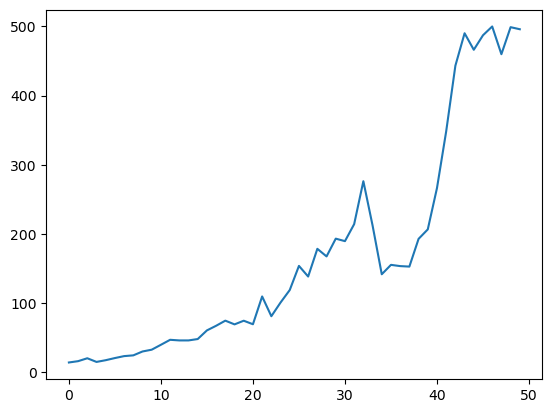

In [16]:
import gymnasium as gym
import matplotlib.pyplot as plt

#env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = gym.make('CartPole-v1', render_mode="rgb_array")
config = {'gamma': .99,
          'learning_rate': 0.01,
          'nb_episodes': 10,
          'entropy_coefficient': 1e-3
         }

pi = policyNetwork(env)
V  = valueNetwork(env)
agent = a2c_agent(config, pi, V)
returns = agent.train(env,50)
plt.plot(returns)

In [17]:
import gymnasium as gym
from gymnasium.utils.save_video import save_video

#test_env = gym.make("LunarLander-v2", render_mode="rgb_array_list")
test_env = gym.make("CartPole-v1", render_mode="rgb_array_list")
s,_ = test_env.reset()
with torch.no_grad():
    for t in range(1000):
        a = pi.sample_action(torch.as_tensor(s))
        s2,r,d,trunc,_ = test_env.step(a)
        s = s2
        if d:
            break

save_video(test_env.render(), "videos", fps=test_env.metadata["render_fps"], name_prefix="a2c_policy")

Moviepy - Building video /home/emmanuel/git_repos/RLclass_MVA/notebooks/videos/a2c_policy-episode-0.mp4.
Moviepy - Writing video /home/emmanuel/git_repos/RLclass_MVA/notebooks/videos/a2c_policy-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/emmanuel/git_repos/RLclass_MVA/notebooks/videos/a2c_policy-episode-0.mp4


In [18]:
from IPython.display import Video
Video("videos/a2c_policy-episode-0.mp4")

# Summary

In this chapter, we have considered the problem of direct policy search. We have:
- cast this problem as a gradient ascent one,
- introduced the policy gradient theorem,
- derived its direct application as the REINFORCE algorithm,
- tackled the problem of gradient variance through the introduction of baselines.
- Since baselines required estimating a value function, we have written actor-critic algorithms,
- and in particular we have introduced the recent A2C algorithm.

Of course there are still lots of things to cover in the literature on policy gradients and more generally policy search. The homework will guide you through some of these important topics, which should provide you with an up-to-date view on the current state-of-the-art in direct policy search.

# Homework

The exercises below are here to help you play with the concepts introduced above, to better grasp them. They also introduce additional important notions. They are not optional to reach the class goals. Often, the provided answer reaches out further than the plain question asked and provides comments, additional insights, or external references.

## Running rollouts in parallel

One key feature of policy gradient algorithms is that they are on-policy: they require the data to have been collected by the current policy, and discard this data once a gradient step is taken. Although this might seem sample inefficient, it can turn out to be an acceptable compromise if the policy gradient steps take the policy towards good returns quickly enough.

A direct consequence of this on-policy property, is that policy gradients don't use experience replay buffers. Instead, they can take advantage of parallel computation to collect samples. We saw that running several rollouts with the same policy greatly helped in reducing the gradient's variance.

<div class="alert alert-warning">
    
**Exercise:**  
Gymnasium provides a [vectorized environments](https://gymnasium.farama.org/api/vector/) class, which enables running multiple independent copies of the same environment in parallel, for a certain number of steps. Modify the REINFORCE and A2C classes to use a vector of environments.
</div>

In [ ]:
# DEMO CODE OF VECTORIZED ENVIRONMENTS
import gymnasium as gym
import numpy as np

## Make vector env and simulate one step
#envs = gym.vector.make("CartPole-v1", num_envs=10)
envs = gym.make_vec("CartPole-v1", num_envs=10)
## Reset all environments
states, _ = envs.reset(seed=42)
#print(states)
## Choose actions
actions = envs.action_space.sample()
#print(actions)
## Step
next_states, rewards, termination, truncation, infos = envs.step(actions)
#print(observations)
#print(infos)

## Warning, when an environment terminates or is truncated, it automatically resets 
## so that you can keep calling .step() and it does not wait idly until others have 
## finished.
## When this happens, the next state returned by .step() is the result of the reset
## and the last state of the previous trajectory is accessed through the 
## infos['final_observation'] variable.
## This also means you cannot use the termination or truncation flags anymore to run 
## post-trajectories computations.

states = next_states
for t in range(50):
    actions = envs.action_space.sample()
    next_states, rewards, termination, truncation, infos = envs.step(actions)
    if any(termination):
        index = np.where(termination == True)
        print("Termination vector:", termination, index)
        index = index[0][0]
        print("Env", index, "has been reset! Here is the last transition:")
        print("starting state =", states[index])
        print("ending state   =", infos['final_observation'][index])
        print("reset state    =", next_states[index])
        break
    states = next_states

In [ ]:
#%load solutions/no_solution_yet.py

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt

#env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = gym.make('CartPole-v1', render_mode="rgb_array")
config = {'gamma': .99,
          'learning_rate': 0.01,
          'nb_episodes': 10,
          'nb_sim_steps_per_update': 500
         }

pi = policyNetwork(env)
agent = reinforce_agent(config, pi)
returns = agent.train(env,50)
plt.plot(returns)

## Policy gradients on continuous action domains

REINFORCE and A2C with Gaussian policies

## Policy gradients for the finite horizon criterion

Derive the PG for the total reward, finite horizon criterion.

Implement a REINFORCE algorithm.

## Generalized advantage estimation

[Generalized Advantage Estimation (Schulman et al., 2016)](https://arxiv.org/abs/1506.02438)

## From off-policy policy gradients to TRPO

[Trust Region Policy Optimization](https://arxiv.org/abs/1502.05477)

Policy gradient methods are intrinsically on-policy algorithms, as states and actions need to be sampled according to $\rho^\pi$ and $\pi$ respectively. But could we make an off-policy version of this gradient estimator?

More precisely, could we use data collected by some policy $\pi$, and the corresponding advantage function $A^{\pi}$, to still compute the gradient of $J(\theta')$?

In this section, we try to write an optimization problem whose gradient can be used to optimize $J(\theta')$ while using samples from $\pi_\theta$.

**$J(\theta')$ as an expression of $\pi$ and $A^\pi$**

Recall that:
$$J(\theta) = \mathbb{E}_{s_0 \sim p_0} \left[ V^\pi(s_0) \right].$$

One can remark that this is also:
$$J(\theta) = \mathbb{E}_{\substack{s_0 \sim p_0\\ s_{t>0}\sim p_t(\cdot|\pi')\\ a_t\sim \pi'}} \left[ V^\pi(s_0) \right].$$

Since the starting state distribution is assumed fixed, we can write:
$$J(\theta) = \mathbb{E}_{\substack{s_t\sim p_t(\cdot|\pi')\\ a_t\sim \pi'}} \left[ V^\pi(s_0) \right].$$

It is tempting to compare this expression of $J(\theta)$ which artificially uses $\pi'$, with that of $J(\theta')$ and make the advantage function of $\pi$ appear, with the intention to write $J(\theta')$ as an expression of $J(\theta)$ and this advantage function. 

Let's first remark that:
\begin{align*}
J(\theta) &= \mathbb{E}_{\substack{s_t\sim p_t(\cdot|\pi')\\ a_t\sim \pi'}} \left[ \sum_{t=0}^\infty \gamma^t V^\pi(s_t) - \sum_{t=1}^\infty \gamma^t V^\pi(s_t) \right],\\
 &= \mathbb{E}_{\substack{s_t\sim p_t(\cdot|\pi')\\ a_t\sim \pi'}} \left[ \sum_{t=0}^\infty \gamma^t \left( V^\pi(s_t) - \gamma V^\pi(s_{t+1}) \right) \right].
\end{align*}

Then recall that $J(\theta') = \mathbb{E}_{\substack{s_t\sim p_t(\cdot|\pi')\\ a_t\sim \pi'}} \left[ \gamma^t r(s_t,a_t) \right]$. So:
\begin{align*}
J(\theta') - J(\theta) &= \mathbb{E}_{\substack{s_t\sim p_t(\cdot|\pi')\\ a_t\sim \pi'}} \left[ \sum_{t=0}^\infty \gamma^t \left( r(s_t, a_t) + \gamma V^\pi(s_{t+1}) - V^\pi(s_t) \right) \right],\\
 &= \mathbb{E}_{\substack{s_t\sim p_t(\cdot|\pi')\\ a_t\sim \pi'}} \left[ \sum_{t=0}^\infty \gamma^t A^\pi(s_t,a_t) \right].
\end{align*}

In other terms:
$$J(\theta') = J(\theta) + \mathbb{E}_{s_t\sim p_t(\cdot|\pi')} \left[ \mathbb{E}_{a_t\sim \pi'} \left[ \sum_{t=0}^\infty \gamma^t A^\pi(s_t,a_t) \right]\right].$$

We have $J(\theta')$ as an expression of $A^\pi$, but we still require sampling according to $\pi'$. Let us first replace all the $p_t$ with the state occupancy measure:
\begin{align*}
J(\theta') &= J(\theta) + \mathbb{E}_{s_t\sim p_t(\cdot|\pi')} \left[ \mathbb{E}_{a_t\sim \pi'} \left[ \sum_{t=0}^\infty \gamma^t A^\pi(s_t,a_t) \right]\right]\\
 &= J(\theta) + \sum_{t=0}^\infty \gamma^t \mathbb{E}_{s_t\sim p_t(\cdot|\pi')} \left[ \mathbb{E}_{a_t\sim \pi'} \left[ A^\pi(s_t,a_t) \right]\right] \\
 &= J(\theta) + \mathbb{E}_{s\sim \rho^{\pi'}} \left[ \mathbb{E}_{a\sim \pi'} \left[ A^\pi(s,a) \right]\right].
\end{align*}

Now we would like to sample according to $\rho^{\pi}$ and $\pi$ instead of $\rho^{\pi'}$ and $\pi'$ so we can use importance sampling:
$$J(\theta') = J(\theta) + \mathbb{E}_{s\sim \rho^{\pi}} \left[ \mathbb{E}_{a\sim \pi} \left[ \frac{\rho^{\pi'}(s)}{\rho^{\pi}(s)} \frac{\pi'(a|s)}{\pi(a|s)} A^\pi(s,a) \right]\right].$$

This is true as long as the distributions due to $\pi$ have non-zero mass where the distributions due to $\pi'$ have non-zero mass.

So in theory, we could calculate our policy score $J(\theta')$ if we knew the ratio $\frac{\rho^{\pi'}(s)}{\rho^{\pi}(s)}$. But it is very unclear how to actually compute this ratio.

One interesting remark is that neural network updates make very small gradient steps on the policy parameters. So it is likely that between two consecutive gradient steps, the policy does not change much, and hopefully the state distribution does no change much either. In that case, we could neglect this ratio and write $\frac{\rho^{\pi'}(s)}{\rho^{\pi}(s)} \approx 1$, which would enable keeping samples collected by $\pi$ in memory and re-using them in:
$$J(\theta') \approx \mathbb{E}_{s\sim\rho^{\pi}} \mathbb{E}_{a\sim \pi} \left[ \frac{\pi'(a|s)}{\pi(a|s)}A^\pi(s,a)\right].$$

**When is $\frac{\rho^{\pi'}(s)}{\rho^{\pi}(s)} \approx 1$?**

**The constrained optimization problem and its Lagrangian**

**Natural policy gradients**

**TRPO**

## PPO

[Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)

## Gradient-free policy search

[Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://arxiv.org/abs/1703.03864)  
[Back to Basics: Benchmarking Canonical Evolution Strategies for Playing Atari](https://arxiv.org/abs/1802.08842)